<h1 style="text-align: center;">Libraries and networks of knowledge: <br/>Using Wikipedia, Wikidata, and archival evidence to reconstruct the social and intellectual network of Jacques Derrida</h1>

In [1]:
import scipy.stats as stats
import pandas as pd
from urllib.request import urlopen
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import seaborn as sns

import networkx as nx
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
from collections import Counter
import powerlaw as plaw

%matplotlib inline
%pylab inline

pd.options.display.max_columns = 500

Populating the interactive namespace from numpy and matplotlib


## 1. Network data

This project represents an intitial attempt to use archival evidence to validate and explore the Wikipedia link network associated with the French philosopher Jacques Derrida. A sample of books with personal dedications from other intellectuals to Derrida was selected from Derrida's personal library, now held by Princeton University. The hypothesis was that these "dedicator nodes" would be useful as reference points in analyzing Derrida's ego network, as encoded in Wikipedia. The project dataset was constructed in several steps:

1. A sample of 150 dedicators was identified and names were reconciled against URIs in the Virtual International Authority File ([VIAF](https://viaf.org/)). From VIAF, Wikidata identifiers were extracted for these nodes.

2. Wikidata lookups were performed to identify the 62 different biographical pages that exist for Derrida across the 285 different language editions of Wikipedia. Links were scraped from these pages and each link was checked in Wikidata to filter out irrelevant nodes. Two filtering criteria were applied: (1) the link must represent a person and (2) that person must have been born after 1889, in order to reasonably overlap with Derrida's own life.

3. A second iteration of link scraping and lookups was performed to harvest the links from the Wikipedia pages for the filtered nodes linked from the Derrida pages.

4. A separate round of two-step harvesting was performed for all of the pages that linked _to_ one of Derrida's pages, again searching across all of the relevant Wikipedia language editions. The [Wikipedia backlink API](https://en.wikipedia.org/wiki/Special:ApiSandbox#action=query&format=xml&list=backlinks&bltitle=Jacques+Derrida&blnamespace=0&bllimit=500) was used to easily identify these links.

The final combined network contained 10737 nodes and 19819 weighted edges. Of these, nodes that were present in only a single weighted edge were removed from the network, resulting in a reduced dataset of 2855 nodes and 11798 edges.

### 1.1 Full network

In [2]:
# Full graph extracted from Wikipedia.

GF = nx.read_graphml(urlopen("https://raw.githubusercontent.com/timathom/netsci/master/project/data/full/full.graphml"))

print(nx.info(GF))

Name: 
Type: DiGraph
Number of nodes: 10737
Number of edges: 19819
Average in degree:   1.8459
Average out degree:   1.8459


The full graph was further processed to flag nodes that only appeared in a single (weighted) edge. In Gephi, single-edge nodes were removed and graph statistics were generated. Two different subsets of the reduced graph were created: 
* one representing Jacques Derrida's first-step ego network
* one limited only to the dedicator nodes within the ego network


### 1.2 Reduced network

In [4]:
GR = nx.read_graphml(urlopen("https://raw.githubusercontent.com/timathom/netsci/master/project/data/reduced/reduced.graphml"))

print(nx.info(GR))

Name: 
Type: DiGraph
Number of nodes: 2855
Number of edges: 11798
Average in degree:   4.1324
Average out degree:   4.1324


### 1.3 Derrida's first-step ego network

In [5]:
GE = nx.read_graphml(urlopen("https://raw.githubusercontent.com/timathom/netsci/master/project/data/reduced/ego/ego.graphml"))

print(nx.info(GE))

Name: 
Type: DiGraph
Number of nodes: 685
Number of edges: 4648
Average in degree:   6.7854
Average out degree:   6.7854


### 1.4 Dedicator nodes within the ego network

In [6]:
GD = nx.read_graphml(urlopen("https://raw.githubusercontent.com/timathom/netsci/master/project/data/reduced/dedicators/dedicators.graphml"))

print(nx.info(GD))

Name: 
Type: DiGraph
Number of nodes: 56
Number of edges: 114
Average in degree:   2.0357
Average out degree:   2.0357


## 2. Simple plots

### 2.0 Full network

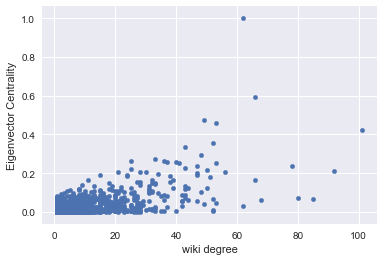

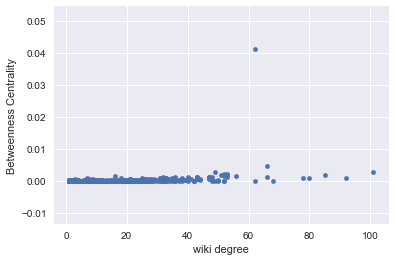

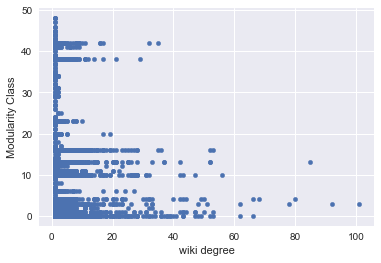

In [15]:
data = "https://raw.githubusercontent.com/timathom/netsci/master/project/data/full/full.csv"
df = pd.read_csv(data)

df.plot(kind="scatter", x="wiki degree", y="Eigenvector Centrality")
df.plot(kind="scatter", x="wiki degree", y="Betweenness Centrality")
df.plot(kind="scatter", x="wiki degree", y="Modularity Class")

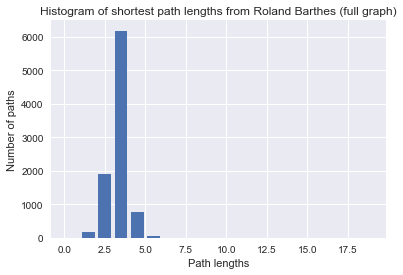

In [16]:
def all_shortest_path_lengths_from(G, node):      
    """
    BSF implementation copied from MIT Open Courseware Lecture 13, Breadth-First Search (BSF): 
    https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-006-introduction-to-algorithms-fall-2011/lecture-videos/lecture-13-breadth-first-search-bfs
    """
    
    level = {node: 0}
    parent = {node: None}
    i = 1
    frontier = [node]
    
    while frontier:
        next_frontier = []
        for u in frontier:
            for v in G[u]:
                if v not in level:
                    level[v] = i
                    parent[v] = u
                    next_frontier.append(v)
        frontier = next_frontier
        i += 1
    
    return level

paths_0 = []
z = all_shortest_path_lengths_from(GF, "Q179109") 
for p, v in z.items():    
    paths_0.append(v)

data = paths_0 
bins = list(range(0, 20, 1))

plt.title("Histogram of shortest path lengths from Roland Barthes (full graph)")
plt.xlabel("Path lengths")
plt.ylabel("Number of paths")
plt.hist(data, bins, histtype="bar", rwidth=0.8)
plt.show()

### 2.1 Reduced network

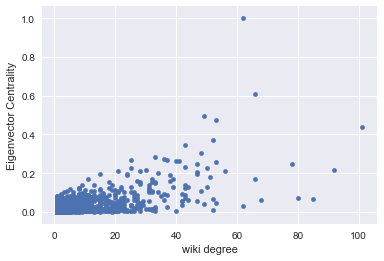

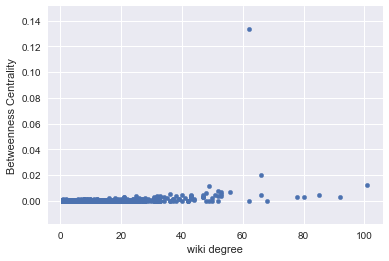

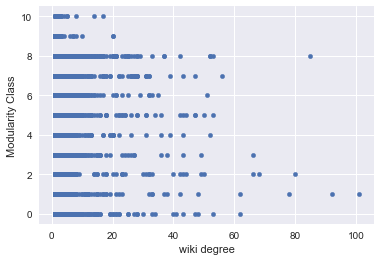

In [9]:
data = "https://raw.githubusercontent.com/timathom/netsci/master/project/data/reduced/reduced.csv"
df = pd.read_csv(data)

df.plot(kind="scatter", x="wiki degree", y="Eigenvector Centrality")
df.plot(kind="scatter", x="wiki degree", y="Betweenness Centrality")
df.plot(kind="scatter", x="wiki degree", y="Modularity Class")

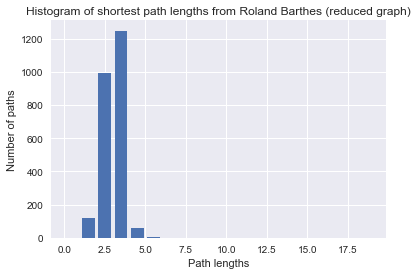

In [19]:
paths_0 = []
z = all_shortest_path_lengths_from(GR, "Q179109") 
for p, v in z.items():    
    paths_0.append(v)

data = paths_0 
bins = list(range(0, 20, 1))

plt.title("Histogram of shortest path lengths from Roland Barthes (reduced graph)")
plt.xlabel("Path lengths")
plt.ylabel("Number of paths")
plt.hist(data, bins, histtype="bar", rwidth=0.8)
plt.show()

### 2.2 Derrida's ego network

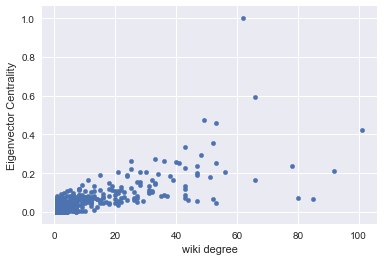

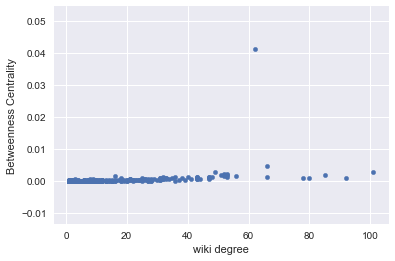

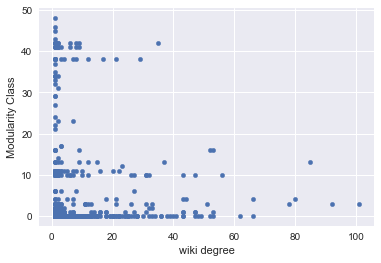

In [11]:
data = "https://raw.githubusercontent.com/timathom/netsci/master/project/data/reduced/ego/ego.csv"
df = pd.read_csv(data)

df.plot(kind="scatter", x="wiki degree", y="Eigenvector Centrality")
df.plot(kind="scatter", x="wiki degree", y="Betweenness Centrality")
df.plot(kind="scatter", x="wiki degree", y="Modularity Class")

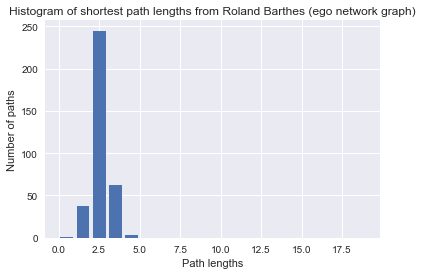

In [21]:
paths_0 = []
z = all_shortest_path_lengths_from(GE, "Q179109") 
for p, v in z.items():    
    paths_0.append(v)

data = paths_0 
bins = list(range(0, 20, 1))

plt.title("Histogram of shortest path lengths from Roland Barthes (ego network graph)")
plt.xlabel("Path lengths")
plt.ylabel("Number of paths")
plt.hist(data, bins, histtype="bar", rwidth=0.8)
plt.show()

### 2.3 Dedicators network

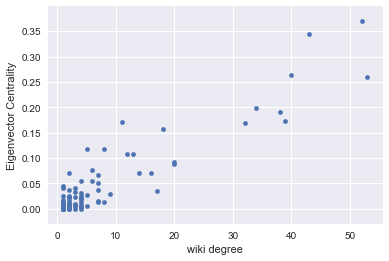

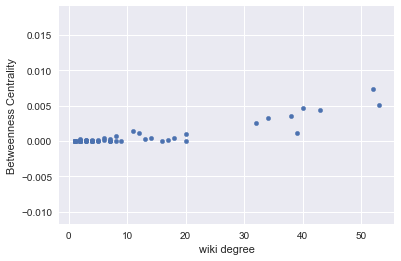

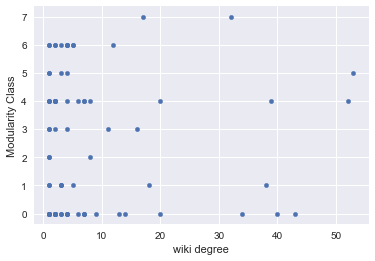

In [90]:
data = "https://raw.githubusercontent.com/timathom/netsci/master/project/data/reduced/dedicators/dedicators.csv"
dfd = pd.read_csv(data)

dfd.plot(kind="scatter", x="wiki degree", y="Eigenvector Centrality")
dfd.plot(kind="scatter", x="wiki degree", y="Betweenness Centrality")
dfd.plot(kind="scatter", x="wiki degree", y="Modularity Class")

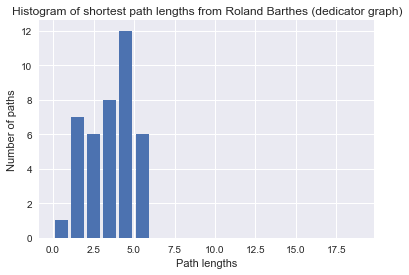

In [23]:
paths_0 = []
z = all_shortest_path_lengths_from(GD, "Q179109") 
for p, v in z.items():    
    paths_0.append(v)

data = paths_0 
bins = list(range(0, 20, 1))

plt.title("Histogram of shortest path lengths from Roland Barthes (dedicator graph)")
plt.xlabel("Path lengths")
plt.ylabel("Number of paths")
plt.hist(data, bins, histtype="bar", rwidth=0.8)
plt.show()